# Article Relevance Prediction for NeotomaDB
## Model Iterations with Word Embeddings

This notebook contains the following tasks:
1. Import cleaned data from "../data/processed/metadata_processed.csv"
2. Add word embeddings
3. Train-Test split
4. Feature Selection
5. Hyperparameter tuning (with MLflow tracking)
6. Best Model

# 1. Import Data

In [1]:
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv, find_dotenv
import mlflow
import azureml
from mlflow.models.signature import infer_signature

load_dotenv(find_dotenv())

AZURE_MLFLOW_URI = os.environ.get("AZURE_MLFLOW_URI")
mlflow.set_tracking_uri(AZURE_MLFLOW_URI)

<Experiment: artifact_location='', creation_time=1685069976001, experiment_id='b6d00221-3fb8-4180-8224-9f7ccea46fb0', last_update_time=None, lifecycle_stage='active', name='kw_iteration1_test', tags={}>

#### Create Training and Testing Data for Model Iteration 1 

In [2]:
import numpy as np
import pandas as pd
metadata_df = pd.read_csv("../data/processed/metadata_processed.csv")
metadata_df.columns

Index(['Unnamed: 0', 'DOI', 'URL', 'abstract', 'author', 'container-title',
       'is-referenced-by-count', 'language', 'published', 'publisher',
       'subject', 'subtitle', 'title', 'target', 'published_year',
       'title_clean', 'subtitle_clean', 'abstract_clean', 'subject_clean',
       'has_abstract', 'text_with_abstract', 'text_wo_abstract', 'detectlang'],
      dtype='object')

In [3]:
training_keepcol = [
       'is-referenced-by-count', 
       'has_abstract', 
       'subject_clean',
       'text_with_abstract', 
       'target']

metadata_df_cleaned = metadata_df.loc[:, training_keepcol]

metadata_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4435 non-null   int64 
 1   has_abstract            4435 non-null   int64 
 2   subject_clean           4346 non-null   object
 3   text_with_abstract      4435 non-null   object
 4   target                  4435 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 173.4+ KB


In [4]:
#empty strings being imported as NaN's, so filling with empty strings
metadata_df_cleaned['subject_clean'] = metadata_df_cleaned['subject_clean'].fillna(value='')

# 2. Add Sentance Embeddings

> !pip install sentence_transformers

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('allenai/specter2')

No sentence-transformers model found with name /Users/kw/.cache/torch/sentence_transformers/allenai_specter2. Creating a new one with MEAN pooling.


In [6]:
# Create sentance embeddings
embeddings = metadata_df_cleaned['text_with_abstract'].apply(model.encode)

In [9]:
embeddings_formatted = pd.DataFrame(embeddings.tolist())
embeddings_formatted

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.367841,-0.682618,0.481659,-0.076614,1.361158,-0.055952,0.724120,0.029236,-0.371343,0.208466,...,-0.043954,0.052891,0.146780,-1.735587,-0.043915,-0.297620,0.090835,0.194451,-0.420138,-0.231142
1,0.436005,0.040026,-0.203677,-0.304372,0.277975,0.072686,0.762866,0.811004,-0.300561,0.721993,...,-0.302171,-0.684025,0.423019,-1.777156,0.134475,-0.994175,0.069995,0.323936,0.398270,-0.962721
2,0.744607,-0.652021,-0.380955,0.007732,0.814745,0.259691,0.131211,-0.164518,0.045866,0.564709,...,-0.041242,0.003290,0.151888,-1.156450,-0.571584,-0.730974,-0.192784,-0.371344,0.129544,-0.870950
3,0.114701,-0.218918,-0.305862,0.614540,0.312255,-0.054838,0.108858,0.566724,-0.105552,0.201352,...,0.097129,-0.540970,-0.165240,-0.534668,-0.509150,-0.612954,-0.172338,-0.157656,-0.290807,-0.581540
4,-0.056214,-0.403606,-0.136764,0.089092,1.015412,0.202195,0.999896,0.329975,-0.535107,0.656730,...,-0.054828,-0.227087,0.086429,-0.868923,-0.564220,-1.107351,-0.470971,0.183784,0.100971,-0.944220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,0.339417,0.101199,-0.458718,0.058226,0.759643,-0.291644,0.643178,0.593418,-0.088356,-0.144444,...,-0.083288,-0.187606,0.160323,-0.668525,-0.386127,-0.943945,-0.193551,0.228726,-0.383796,-0.855458
4431,0.269436,-0.041214,0.302663,0.339386,0.111603,-0.455084,-0.111151,1.140449,-0.013668,-0.019977,...,0.135322,0.304750,0.686558,-0.649246,-0.523400,-0.502265,-0.724967,0.285527,-0.024432,-0.772663
4432,0.319937,-0.013901,0.332743,0.412342,0.308393,-0.295955,0.754990,0.423491,-0.381034,0.210434,...,-0.444082,-0.698346,0.242722,-1.255496,-0.090500,-0.399208,-0.166269,-0.041473,-0.598962,-0.606830
4433,-0.070910,-0.745114,-0.032809,0.515964,0.676877,-0.072093,0.420317,0.511388,-0.044020,0.234968,...,-0.007636,0.587618,0.460993,-0.659403,-0.442102,-0.274008,0.179789,-0.276637,-0.229170,-0.824705


In [10]:
#save embeddings
embeddings_formatted.to_csv("../data/processed/embeddings.csv")

In [11]:
# Read From Dataframe
embeddings_df = pd.read_csv("../data/processed/embeddings.csv", index_col=0)
embeddings_df.columns = embeddings_df.columns.astype(str) # require column names as strings for modelling
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.367841,-0.682618,0.481659,-0.076614,1.361158,-0.055952,0.724120,0.029236,-0.371343,0.208466,...,-0.043954,0.052891,0.146780,-1.735587,-0.043915,-0.297620,0.090835,0.194451,-0.420138,-0.231142
1,0.436005,0.040026,-0.203677,-0.304372,0.277975,0.072686,0.762866,0.811004,-0.300561,0.721993,...,-0.302171,-0.684025,0.423019,-1.777157,0.134475,-0.994175,0.069995,0.323936,0.398270,-0.962721
2,0.744607,-0.652021,-0.380955,0.007732,0.814745,0.259691,0.131211,-0.164518,0.045866,0.564709,...,-0.041242,0.003290,0.151888,-1.156450,-0.571584,-0.730974,-0.192784,-0.371344,0.129544,-0.870950
3,0.114701,-0.218918,-0.305862,0.614540,0.312255,-0.054838,0.108858,0.566724,-0.105552,0.201352,...,0.097129,-0.540970,-0.165240,-0.534668,-0.509150,-0.612954,-0.172338,-0.157656,-0.290807,-0.581540
4,-0.056214,-0.403606,-0.136764,0.089092,1.015412,0.202195,0.999896,0.329975,-0.535107,0.656730,...,-0.054828,-0.227087,0.086429,-0.868923,-0.564220,-1.107351,-0.470971,0.183784,0.100971,-0.944220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,0.339417,0.101199,-0.458718,0.058226,0.759644,-0.291644,0.643178,0.593418,-0.088356,-0.144444,...,-0.083288,-0.187606,0.160323,-0.668525,-0.386127,-0.943945,-0.193551,0.228726,-0.383796,-0.855458
4431,0.269436,-0.041214,0.302663,0.339386,0.111603,-0.455084,-0.111151,1.140449,-0.013668,-0.019977,...,0.135322,0.304750,0.686558,-0.649246,-0.523401,-0.502265,-0.724967,0.285527,-0.024432,-0.772663
4432,0.319937,-0.013901,0.332743,0.412342,0.308393,-0.295955,0.754990,0.423491,-0.381034,0.210434,...,-0.444082,-0.698346,0.242723,-1.255496,-0.090500,-0.399208,-0.166269,-0.041473,-0.598962,-0.606830
4433,-0.070910,-0.745114,-0.032809,0.515964,0.676877,-0.072093,0.420317,0.511388,-0.044020,0.234968,...,-0.007636,0.587618,0.460993,-0.659403,-0.442102,-0.274008,0.179789,-0.276637,-0.229170,-0.824705


In [12]:
# Joining embeddings to DataFrame
metadata_df_cleaned = pd.concat([metadata_df_cleaned, embeddings_df], axis = 1)
metadata_df_cleaned

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,0,1,2,3,4,...,758,759,760,761,762,763,764,765,766,767
0,13,1,Cell Biology Plant Science Genetics Molecular ...,The long-term succession of cladoceran fauna a...,1,-0.367841,-0.682618,0.481659,-0.076614,1.361158,...,-0.043954,0.052891,0.146780,-1.735587,-0.043915,-0.297620,0.090835,0.194451,-0.420138,-0.231142
1,81,1,"Paleontology Earth-Surface Processes Ecology, ...",Late-glacial and Holocene vegetational history...,1,0.436005,0.040026,-0.203677,-0.304372,0.277975,...,-0.302171,-0.684025,0.423019,-1.777157,0.134475,-0.994175,0.069995,0.323936,0.398270,-0.962721
2,14,1,"Environmental Science (miscellaneous) Ecology,...",Vegetation Responses to Changing Fire Regimes ...,1,0.744607,-0.652021,-0.380955,0.007732,0.814745,...,-0.041242,0.003290,0.151888,-1.156450,-0.571584,-0.730974,-0.192784,-0.371344,0.129544,-0.870950
3,9,0,General Earth and Planetary Sciences Archeology,University of Wisconsin Radiocarbon Dates XXIV...,1,0.114701,-0.218918,-0.305862,0.614540,0.312255,...,0.097129,-0.540970,-0.165240,-0.534668,-0.509150,-0.612954,-0.172338,-0.157656,-0.290807,-0.581540
4,41,0,General Earth and Planetary Sciences Archeology,Chronology of Vegetation and Paleoclimatic Sta...,1,-0.056214,-0.403606,-0.136764,0.089092,1.015412,...,-0.054828,-0.227087,0.086429,-0.868923,-0.564220,-1.107351,-0.470971,0.183784,0.100971,-0.944220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,0,0,Multidisciplinary,"Trophic relationship between Salix flowers, Or...",0,0.339417,0.101199,-0.458718,0.058226,0.759644,...,-0.083288,-0.187606,0.160323,-0.668525,-0.386127,-0.943945,-0.193551,0.228726,-0.383796,-0.855458
4431,7,0,Immunology Immunology and Allergy,Sensitization to Gibberellin-Regulated Protein...,0,0.269436,-0.041214,0.302663,0.339386,0.111603,...,0.135322,0.304750,0.686558,-0.649246,-0.523401,-0.502265,-0.724967,0.285527,-0.024432,-0.772663
4432,3,0,General Agricultural and Biological Sciences G...,Contrasting the ecological effects of decreasi...,1,0.319937,-0.013901,0.332743,0.412342,0.308393,...,-0.444082,-0.698346,0.242723,-1.255496,-0.090500,-0.399208,-0.166269,-0.041473,-0.598962,-0.606830
4433,4,0,,Clinical and radiological characteristics of C...,0,-0.070910,-0.745114,-0.032809,0.515964,0.676877,...,-0.007636,0.587618,0.460993,-0.659403,-0.442102,-0.274008,0.179789,-0.276637,-0.229170,-0.824705


# 3. Train-Test Split

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [14]:
train_df, test_df = train_test_split(metadata_df_cleaned, test_size=0.2, random_state=123)
train_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,0,1,2,3,4,...,758,759,760,761,762,763,764,765,766,767
1094,2,1,"Ecology Aquatic Science Geography, Planning an...",Guest Editor’s Introduction,0,0.653250,0.798155,0.035585,0.387167,-0.156542,...,-0.242378,0.503465,0.032498,-0.567614,-0.426187,-0.503174,-0.428051,-0.532983,-0.357451,-0.763496
1798,0,1,Applied Mathematics,Editorial Board,0,0.951775,0.886975,-0.486090,0.205144,0.280177,...,-0.744673,0.610511,-0.102627,-0.650131,-0.610828,-0.624781,-0.528421,-0.478678,-0.389042,-0.571375
1843,16,1,Infectious Diseases,Continued high incidence of children with seve...,0,0.448285,0.340418,0.070460,0.480703,0.761571,...,0.082882,0.003176,0.561748,-0.719715,0.181811,-0.029516,-0.003262,-0.435644,-0.291620,-1.161194
1613,4,1,Economics and Econometrics,Biological Analogies in Economics: A Comment,0,0.277633,0.434886,0.315255,-0.014277,1.167029,...,-0.637709,0.177415,0.187346,-0.806112,-0.397028,-0.702644,-0.570996,-0.325803,-0.531645,-0.262768
168,20,1,"Ecology Ecology, Evolution, Behavior and Syste...",Postglacial Rise and Decline of Ostrya virgini...,1,0.153058,-0.365222,-0.352635,0.004103,0.589912,...,-0.187236,0.143116,-0.322254,-0.784112,-0.362402,-0.671007,-0.599852,0.407985,-0.414845,-0.179443


### EDA for Train Split

In [16]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 1094 to 3582
Columns: 773 entries, is-referenced-by-count to 767
dtypes: float64(768), int64(3), object(2)
memory usage: 21.0+ MB


In [17]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

In [19]:
print("With Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_with_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_with_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_with_abstract.str.len().mean()
avg_neg_len = neg_df.text_with_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)

With Abstract
715.1986206896552
850.9546581650726


In [23]:
# sorted_pos_df.head()

In [22]:
# sorted_neg_df.head()

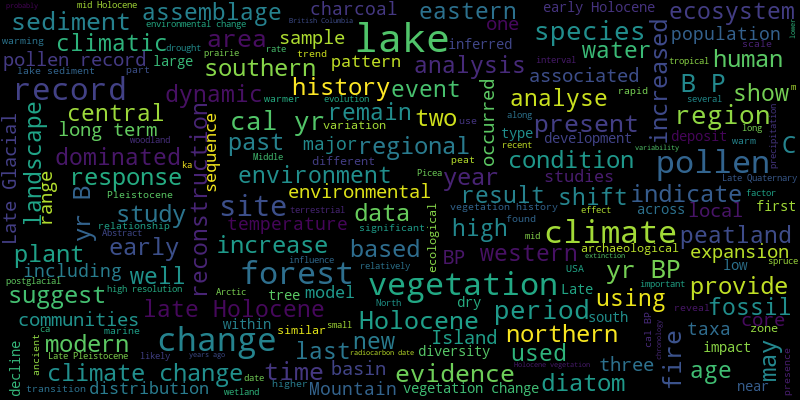

In [25]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text_with_abstract"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text_with_abstract"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

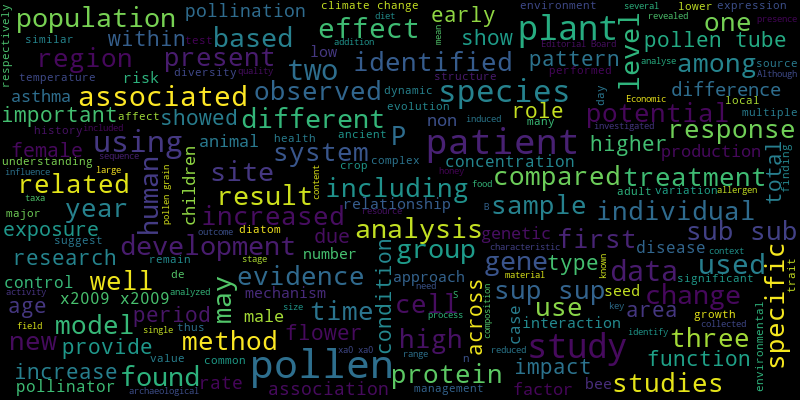

In [26]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [27]:
train_df["target"].value_counts(normalize=True)

0    0.79566
1    0.20434
Name: target, dtype: float64

# 4. Modelling with Sentence Embeddings

### 4.1 Preprocessor

In [28]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [29]:
train_df.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target', '0', '1', '2', '3', '4',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=773)

In [30]:
X_train, y_train = train_df.drop(columns = ["target", "text_with_abstract"]), train_df["target"]
X_test, y_test = test_df.drop(columns = ["target", "text_with_abstract"]), test_df["target"]

In [31]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer

# Dividing the feature types
text_features = "subject_clean"
text_transformer = CountVectorizer(stop_words="english", max_features= 1000)

binary_feature = ['has_abstract']
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

numeric_features = ["is-referenced-by-count"]
numeric_transformer = StandardScaler()

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers = [
    ("num_preprocessor", numeric_transformer, numeric_features),
    ("binary_preprocessor", binary_transformer, binary_feature),
    ("text_preprocessor", text_transformer, text_features)
    ],
    remainder = "passthrough"
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_preprocessor', StandardScaler(),
                                 ['is-referenced-by-count']),
                                ('binary_preprocessor',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['has_abstract']),
                                ('text_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'subject_clean')])

##### Check Transformed Data

In [32]:
transformed_X_train = preprocessor.fit_transform(X_train)
transformed_X_train

array([[-0.335283  ,  1.        ,  0.        , ..., -0.5329829 ,
        -0.35745063, -0.76349574],
       [-0.38642152,  1.        ,  0.        , ..., -0.47867817,
        -0.38904217, -0.5713748 ],
       [ 0.02268659,  1.        ,  0.        , ..., -0.43564442,
        -0.29162022, -1.1611944 ],
       ...,
       [-0.38642152,  1.        ,  0.        , ..., -0.12497892,
         0.10995826, -0.37614492],
       [-0.38642152,  0.        ,  0.        , ..., -0.26709256,
        -0.10828786, -1.0894089 ],
       [-0.38642152,  0.        ,  0.        , ...,  0.04213829,
         0.1705434 , -0.72560143]])

In [34]:
col_names = (preprocessor.named_transformers_["num_preprocessor"].get_feature_names_out().tolist() +
             preprocessor.named_transformers_["binary_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist() + 
             embeddings_df.columns.tolist())
len(col_names)

1093

In [35]:
transformed_X_train_df = pd.DataFrame(transformed_X_train, columns=col_names)
transformed_X_train_df.head(3)

,is-referenced-by-count,has_abstract_1,accounting,administration,advanced,aerospace,aging,agricultural,agronomy,aided,...,758,759,760,761,762,763,764,765,766,767
0,-0.335283,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.242378,0.503465,0.032498,-0.567614,-0.426187,-0.503174,-0.428051,-0.532983,-0.357451,-0.763496
1,-0.386422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.744673,0.610511,-0.102627,-0.650131,-0.610828,-0.624781,-0.528421,-0.478678,-0.389042,-0.571375
2,0.022687,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.082882,0.003176,0.561748,-0.719715,0.181811,-0.029516,-0.003262,-0.435644,-0.291620,-1.161194


### 4.2 Model Comparison

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [38]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [40]:
classification_metrics = ["accuracy", "precision", "recall", "f1"]

In [41]:
results_dict = {}
models = {
	"dummy": DummyClassifier(random_state = 123),
  "logistic regression": LogisticRegression(max_iter=1000, random_state=123),
    "decision tree": DecisionTreeClassifier(random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    'NaiveBayes': BernoulliNB(alpha=1),
    "RBF SVM": SVC(random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(random_state=123),
    'Cat Boost': CatBoostClassifier(verbose=0, random_state=123),
    'XGB' : XGBClassifier(random_state=123, verbosity=0),
    'sklearn_histGB': HistGradientBoostingClassifier(random_state=123),
    "sklearn_GB": GradientBoostingClassifier(random_state=123)
    }

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df


/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.048 (+/- 0.015),0.017 (+/- 0.004),0.796 (+/- 0.000),0.796 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,0.574 (+/- 0.091),0.020 (+/- 0.002),0.964 (+/- 0.004),0.995 (+/- 0.001),0.922 (+/- 0.020),0.994 (+/- 0.003),0.902 (+/- 0.026),0.984 (+/- 0.004),0.911 (+/- 0.011),0.989 (+/- 0.003)
decision tree,2.335 (+/- 0.466),0.015 (+/- 0.001),0.911 (+/- 0.009),1.000 (+/- 0.000),0.789 (+/- 0.025),1.000 (+/- 0.000),0.771 (+/- 0.062),1.000 (+/- 0.000),0.778 (+/- 0.028),1.000 (+/- 0.000)
kNN,0.042 (+/- 0.004),0.081 (+/- 0.038),0.963 (+/- 0.008),0.974 (+/- 0.001),0.953 (+/- 0.014),0.970 (+/- 0.003),0.861 (+/- 0.036),0.903 (+/- 0.004),0.904 (+/- 0.022),0.935 (+/- 0.003)
NaiveBayes,0.076 (+/- 0.006),0.023 (+/- 0.001),0.914 (+/- 0.007),0.915 (+/- 0.001),0.713 (+/- 0.017),0.715 (+/- 0.003),0.967 (+/- 0.011),0.971 (+/- 0.002),0.821 (+/- 0.012),0.824 (+/- 0.002)
RBF SVM,0.718 (+/- 0.028),0.165 (+/- 0.009),0.969 (+/- 0.006),0.976 (+/- 0.002),0.968 (+/- 0.013),0.977 (+/- 0.004),0.877 (+/- 0.030),0.903 (+/- 0.005),0.920 (+/- 0.017),0.939 (+/- 0.004)
RF,3.066 (+/- 0.096),0.030 (+/- 0.002),0.957 (+/- 0.007),1.000 (+/- 0.000),0.961 (+/- 0.019),1.000 (+/- 0.000),0.825 (+/- 0.019),1.000 (+/- 0.000),0.888 (+/- 0.017),1.000 (+/- 0.000)
LGBM,2.144 (+/- 0.084),0.021 (+/- 0.001),0.967 (+/- 0.005),1.000 (+/- 0.000),0.946 (+/- 0.018),1.000 (+/- 0.000),0.890 (+/- 0.019),1.000 (+/- 0.000),0.917 (+/- 0.012),1.000 (+/- 0.000)
Cat Boost,45.338 (+/- 2.592),0.188 (+/- 0.005),0.971 (+/- 0.006),1.000 (+/- 0.000),0.958 (+/- 0.022),1.000 (+/- 0.000),0.897 (+/- 0.022),1.000 (+/- 0.000),0.926 (+/- 0.016),1.000 (+/- 0.000)
XGB,4.916 (+/- 0.338),0.026 (+/- 0.002),0.966 (+/- 0.005),1.000 (+/- 0.000),0.941 (+/- 0.015),1.000 (+/- 0.000),0.891 (+/- 0.019),1.000 (+/- 0.000),0.915 (+/- 0.012),1.000 (+/- 0.000)


##### Summary of models
- Naive Bayes has the highest test recall but the precision is too low and will introduce many false positives.
- sklearn_GB and CatBoost has high f1 but their fit time is very long - not practical
- logistic regression and LGBM has high recall, f1 and reasonable fit time and precision

### 4.3 Logistic Regression Model Evaluation

##### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression 

# The model pipeline

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe

classification_metrics = ["accuracy", "precision", "recall", "f1"]

cross_val_results= {}
cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

,mean,std
fit_time,1.079,0.087
score_time,0.033,0.005
test_accuracy,0.967,0.004
train_accuracy,0.996,0.001
test_precision,0.934,0.012
train_precision,0.995,0.003
test_recall,0.904,0.009
train_recall,0.985,0.004
test_f1,0.919,0.009
train_f1,0.990,0.002


##### Feature importance for Logistic Regression

In [28]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [29]:
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [30]:
data = {
    "coefficient": logreg_model.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

,coefficient,magnitude
archeology,1.409828,1.409828
paleontology,0.945548,0.945548
732,0.907300,0.907300
110,0.899695,0.899695
581,0.888129,0.888129
573,0.801779,0.801779
155,0.795223,0.795223
180,0.793460,0.793460
532,0.785945,0.785945
350,0.769437,0.769437


In [31]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

,coefficient,magnitude
multidisciplinary,-1.426207,1.426207
718,-1.049860,1.049860
55,-0.979836,0.979836
761,-0.945828,0.945828
561,-0.804155,0.804155
37,-0.795770,0.795770
393,-0.774409,0.774409
537,-0.767976,0.767976
202,-0.766721,0.766721
175,-0.739919,0.739919


In [32]:
from sklearn.metrics import recall_score
# Make predictions
predictions = logreg_model.predict(X_train)

# Add the predictions to the original DataFrame
train_df['predictions'] = predictions

# Group the data by a specific feature
grouped_data = train_df.groupby('has_abstract')

# Calculate recall for each group
grouped_recall = grouped_data.apply(lambda x: recall_score(x['target'], x['predictions']))

# Print the recall by group
print(grouped_recall)

has_abstract
0    0.96
1    1.00
dtype: float64


##### Model Mistakes

In [33]:
logreg_model.fit(X_train, y_train)

train_df['y_pred'] = logreg_model.predict(X_train)
# train_df['y_predictproba'] = logreg_model.predict_proba(X_train)

train_df.head(5)

# False Positives
train_df.query('target == 0 & y_pred == 1')

# False Negative
train_df.query('target == 1 & y_pred == 0')

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,text_wo_abstract,target,0,1,2,3,...,760,761,762,763,764,765,766,767,predictions,y_pred
3372,12,0,"Library and Information Sciences Statistics, P...","p3k14c, a synthetic global database of archaeo...","p3k14c, a synthetic global database of archaeo...",1,0.213396,0.042437,0.097543,-0.164637,...,0.407151,-0.878209,-0.153351,-0.412318,-0.453711,-0.170426,0.240408,-1.037293,0,0
3397,0,0,Plant Science,Fossil pollen resolves origin of the South Afr...,Fossil pollen resolves origin of the South Afr...,1,0.799007,0.072415,0.167970,-0.102467,...,0.315138,-0.389148,0.214993,-0.946495,-0.506958,0.467604,0.129413,-0.569880,0,0
2536,0,0,Multidisciplinary,“Well” off in animals: A taphonomic history of...,“Well” off in animals: A taphonomic history of...,1,0.132057,0.247640,0.273822,0.165507,...,0.391908,-0.688703,-0.699732,-0.361962,-0.510942,-0.231760,-0.395011,-0.694757,0,0
3558,12,0,General Immunology and Microbiology General Bi...,Ancient DNA reveals the lost domestication his...,Ancient DNA reveals the lost domestication his...,1,0.489508,0.347412,0.127197,-0.016068,...,0.558301,-0.782260,-0.180607,-0.298737,-0.501164,-0.121281,-0.218225,-0.662976,0,0
3447,3,0,"Anthropology Ecology, Evolution, Behavior and ...",Evidence of habitual behavior from non-aliment...,Evidence of habitual behavior from non-aliment...,1,0.587087,0.853532,0.035451,-0.173374,...,0.318171,-1.114613,-0.662820,-0.602304,-0.060114,-0.384035,-0.239291,-0.584039,0,0
3905,36,0,Multidisciplinary,The Emergence of Animal Management in the Sout...,The Emergence of Animal Management in the Sout...,1,0.438775,0.416888,0.103239,-0.139776,...,0.280307,-0.551912,-0.379107,-0.712601,-0.623073,-0.005573,0.045461,-0.601610,0,0
4106,62,0,Multidisciplinary,Identifying early modern human ecological nich...,Identifying early modern human ecological nich...,1,0.583869,-0.080542,0.205314,0.090711,...,0.385519,-0.605621,-0.154782,-0.611014,-0.315918,0.027246,0.193550,-0.833747,0,0
3592,18,0,Multidisciplinary,Living off the land: Terrestrial-based diet an...,Living off the land: Terrestrial-based diet an...,1,0.409894,0.409192,0.099977,0.083620,...,0.353856,-0.745450,-0.831885,-0.723577,-0.249806,-0.109471,-0.005812,-0.713384,0,0
2616,32,0,Multidisciplinary,Dire wolves were the last of an ancient New Wo...,Dire wolves were the last of an ancient New Wo...,1,0.120220,0.490394,0.118549,-0.317582,...,0.367878,-0.400605,0.017071,-0.228756,-0.401369,0.227250,-0.083113,-0.571556,0,0
4033,19,0,"Health, Toxicology and Mutagenesis Pollution E...",Phytoplankton functional groups in a monomicti...,Phytoplankton functional groups in a monomicti...,1,-0.059075,-0.369456,0.463117,0.491769,...,-0.068452,-1.347685,-0.328752,-0.619133,-0.431279,-0.047673,-0.920533,-0.608456,0,0


### 4.4 Feature Selection

In [37]:
from sklearn.feature_selection import SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results_dict[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=classification_metrics
    )

In [38]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.071 (+/- 0.005),0.027 (+/- 0.002),0.794 (+/- 0.001),0.794 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,1.150 (+/- 0.261),0.033 (+/- 0.013),0.967 (+/- 0.004),0.996 (+/- 0.001),0.934 (+/- 0.012),0.995 (+/- 0.003),0.904 (+/- 0.009),0.985 (+/- 0.004),0.919 (+/- 0.009),0.990 (+/- 0.002)
decision tree,3.496 (+/- 0.129),0.021 (+/- 0.004),0.908 (+/- 0.008),1.000 (+/- 0.000),0.779 (+/- 0.029),1.000 (+/- 0.000),0.772 (+/- 0.024),1.000 (+/- 0.000),0.775 (+/- 0.019),1.000 (+/- 0.000)
kNN,0.058 (+/- 0.016),0.253 (+/- 0.058),0.966 (+/- 0.007),0.975 (+/- 0.001),0.964 (+/- 0.012),0.971 (+/- 0.006),0.866 (+/- 0.029),0.903 (+/- 0.005),0.912 (+/- 0.018),0.936 (+/- 0.002)
NaiveBayes,0.126 (+/- 0.016),0.041 (+/- 0.004),0.913 (+/- 0.013),0.914 (+/- 0.004),0.713 (+/- 0.032),0.714 (+/- 0.009),0.969 (+/- 0.008),0.972 (+/- 0.003),0.821 (+/- 0.022),0.823 (+/- 0.007)
RBF SVM,0.649 (+/- 0.025),0.289 (+/- 0.067),0.968 (+/- 0.004),0.976 (+/- 0.001),0.964 (+/- 0.008),0.978 (+/- 0.005),0.875 (+/- 0.016),0.903 (+/- 0.007),0.918 (+/- 0.011),0.939 (+/- 0.003)
RF,4.309 (+/- 0.167),0.041 (+/- 0.008),0.957 (+/- 0.005),1.000 (+/- 0.000),0.966 (+/- 0.007),1.000 (+/- 0.000),0.819 (+/- 0.021),1.000 (+/- 0.000),0.887 (+/- 0.015),1.000 (+/- 0.000)
LGBM,11.065 (+/- 0.848),0.029 (+/- 0.007),0.969 (+/- 0.006),1.000 (+/- 0.000),0.952 (+/- 0.022),1.000 (+/- 0.000),0.896 (+/- 0.010),1.000 (+/- 0.000),0.923 (+/- 0.014),1.000 (+/- 0.000)
XGB,23.929 (+/- 6.230),0.030 (+/- 0.010),0.967 (+/- 0.006),1.000 (+/- 0.000),0.948 (+/- 0.017),1.000 (+/- 0.000),0.889 (+/- 0.016),1.000 (+/- 0.000),0.917 (+/- 0.014),1.000 (+/- 0.000)
sklearn_histGB,12.828 (+/- 0.434),0.032 (+/- 0.002),0.969 (+/- 0.006),1.000 (+/- 0.000),0.952 (+/- 0.020),1.000 (+/- 0.000),0.895 (+/- 0.012),1.000 (+/- 0.000),0.922 (+/- 0.015),1.000 (+/- 0.000)


#### Results
Since interpretability is not a major concern for us, it appears that Feature selection does not provide us with better results. It decreases reduces the dimensionality of the model, but also decreases recall. While Naive Bayes provides the highest Recall score amongst the models, this model has a low precision which results in a lower F1 score. So, we have decided to move forward with Logistic Regression and LGBM instead. 

In [39]:
pipe_LGBM = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["LGBM"],
)

pipe_LGBM.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_LGBM.named_steps["lgbmclassifier"].n_features_in_,
)

Number of features selected:  178


In [40]:
 pipe_logreg = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["logistic regression"],
)

pipe_logreg.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_logreg.named_steps["logisticregression"].n_features_in_,
)

Number of features selected:  180


# 5. Hyperparmeter Optimization

In [44]:
# !pip install hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

In [45]:
metrics = ["accuracy", "precision", "recall", "f1"]

def objective(params):

    classifier_type = params['type']
    del params['type']

    if classifier_type == 'logistic_regression':
        clf = LogisticRegression(max_iter=10000, random_state=123, **params)
    elif classifier_type == 'lgbm':
        clf = LGBMClassifier(class_weight = "balanced", random_state=123, **params)
    else:
        return 0

    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", clf),
        ]
    )

    # manually run cross_validate and get recall
    model_cv_results = pd.DataFrame(cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=metrics,
        return_train_score=True,
        n_jobs=-1,
    )).agg(["mean", "std"]).T
    
    # log metrics to mlflow
    with mlflow.start_run():

        # log train and test for each metric
        for m in metrics:
            mlflow.log_metric(f"{m}_train_mean", model_cv_results.loc[f"train_{m}"]["mean"])
            mlflow.log_metric(f"{m}_test_mean", model_cv_results.loc[f"test_{m}"]["mean"])
            mlflow.log_metric(f"{m}_train_std", model_cv_results.loc[f"train_{m}"]["std"])
            mlflow.log_metric(f"{m}_test_std", model_cv_results.loc[f"test_{m}"]["std"])

        # log params
        mlflow.log_params(params)
        # log the type of model
        mlflow.log_param("model_type", classifier_type)

        # log model
        if classifier_type == "lgbm":
            mlflow.lightgbm.log_model(pipe, "model", signature=infer_signature(X_train, y_train))
        elif classifier_type == "logistic_regression":
            mlflow.sklearn.log_model(pipe, "model", signature=infer_signature(X_train, y_train))

    # make recall positive so it maximizes it 
    result = {'loss': -model_cv_results.loc["test_" + metrics[0]]["mean"], 
              'status': STATUS_OK}

    return result

In [53]:
mlflow.set_experiment("kw_iteration1_LGBM100")

2023/05/25 23:44:42 INFO mlflow.tracking.fluent: Experiment with name 'kw_iteration1_LGBM100' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1685083483173, experiment_id='5450499b-e65f-4061-865d-312e0ebc0f3a', last_update_time=None, lifecycle_stage='active', name='kw_iteration1_LGBM100', tags={}>

### 5.1 Logistic Regression Hyperparameter Tuning

In [72]:
mlflow.set_experiment("kw_iteration1_LogReg80_noEarlyStop")

search_space = hp.choice('classifier_type', [
    {
        'type': 'logistic_regression',
        'C': hp.uniform('logisticregression__C', 0.1, 100),
    }
])

search_algorithm = tpe.suggest

best_lr_hyperparams = fmin(
fn=objective, 
space=search_space,
algo=search_algorithm,
max_evals=80,
trials= Trials())

  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_P

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  1%|▏         | 1/80 [00:23<31:23, 23.85s/trial, best loss: -0.9580043306382725]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  2%|▎         | 2/80 [00:44<28:51, 22.20s/trial, best loss: -0.9580043306382725]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  4%|▍         | 3/80 [01:04<27:09, 21.16s/trial, best loss: -0.9580043306382725]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  5%|▌         | 4/80 [01:23<25:44, 20.33s/trial, best loss: -0.9580043306382725]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  6%|▋         | 5/80 [01:43<25:10, 20.14s/trial, best loss: -0.9580043306382725]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  8%|▊         | 6/80 [02:02<24:08, 19.57s/trial, best loss: -0.9580043306382725]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  9%|▉         | 7/80 [02:23<24:19, 20.00s/trial, best loss: -0.9580043306382725]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 10%|█         | 8/80 [02:41<23:28, 19.56s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 11%|█▏        | 9/80 [03:00<22:59, 19.43s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 12%|█▎        | 10/80 [03:20<22:55, 19.65s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 14%|█▍        | 11/80 [03:39<22:04, 19.20s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 15%|█▌        | 12/80 [03:57<21:36, 19.07s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 16%|█▋        | 13/80 [04:15<20:49, 18.65s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 18%|█▊        | 14/80 [04:37<21:43, 19.74s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 19%|█▉        | 15/80 [04:57<21:22, 19.73s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 20%|██        | 16/80 [05:16<20:49, 19.52s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 21%|██▏       | 17/80 [05:34<19:50, 18.90s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 22%|██▎       | 18/80 [05:51<18:57, 18.34s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 24%|██▍       | 19/80 [06:08<18:27, 18.15s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 25%|██▌       | 20/80 [06:26<18:02, 18.04s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 26%|██▋       | 21/80 [06:42<17:06, 17.40s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 28%|██▊       | 22/80 [07:00<16:53, 17.48s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 29%|██▉       | 23/80 [07:15<16:02, 16.89s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 30%|███       | 24/80 [07:32<15:44, 16.87s/trial, best loss: -0.9636413119052822]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 31%|███▏      | 25/80 [07:47<15:00, 16.38s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 32%|███▎      | 26/80 [08:04<14:46, 16.43s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 34%|███▍      | 27/80 [08:21<14:44, 16.68s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 35%|███▌      | 28/80 [08:38<14:39, 16.92s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 36%|███▋      | 29/80 [08:54<14:07, 16.61s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 38%|███▊      | 30/80 [09:12<14:10, 17.02s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 39%|███▉      | 31/80 [09:31<14:13, 17.41s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 40%|████      | 32/80 [09:50<14:17, 17.87s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 41%|████▏     | 33/80 [10:07<13:58, 17.83s/trial, best loss: -0.9639230020461274]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 42%|████▎     | 34/80 [10:21<12:41, 16.54s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 44%|████▍     | 35/80 [10:38<12:30, 16.67s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 45%|████▌     | 36/80 [10:57<12:47, 17.43s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 46%|████▋     | 37/80 [11:19<13:31, 18.87s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 48%|████▊     | 38/80 [11:40<13:29, 19.28s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 49%|████▉     | 39/80 [11:59<13:11, 19.29s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 50%|█████     | 40/80 [12:18<12:46, 19.17s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 51%|█████▏    | 41/80 [12:34<11:55, 18.35s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 52%|█████▎    | 42/80 [12:54<11:54, 18.79s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 54%|█████▍    | 43/80 [13:13<11:42, 18.98s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 55%|█████▌    | 44/80 [13:35<11:46, 19.62s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 56%|█████▋    | 45/80 [13:51<10:50, 18.57s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 57%|█████▊    | 46/80 [14:06<09:55, 17.52s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 59%|█████▉    | 47/80 [14:26<10:04, 18.31s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 60%|██████    | 48/80 [14:46<09:59, 18.72s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 61%|██████▏   | 49/80 [15:06<09:55, 19.21s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 62%|██████▎   | 50/80 [15:28<10:05, 20.18s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 64%|██████▍   | 51/80 [15:50<09:59, 20.66s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 65%|██████▌   | 52/80 [16:11<09:42, 20.82s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 66%|██████▋   | 53/80 [16:31<09:13, 20.50s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 68%|██████▊   | 54/80 [16:49<08:30, 19.62s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 69%|██████▉   | 55/80 [17:09<08:18, 19.93s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 70%|███████   | 56/80 [17:28<07:46, 19.43s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 71%|███████▏  | 57/80 [17:46<07:23, 19.27s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 72%|███████▎  | 58/80 [18:04<06:55, 18.90s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 74%|███████▍  | 59/80 [18:26<06:54, 19.76s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 75%|███████▌  | 60/80 [18:49<06:53, 20.67s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 76%|███████▋  | 61/80 [19:06<06:14, 19.69s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 78%|███████▊  | 62/80 [19:27<05:59, 19.95s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 79%|███████▉  | 63/80 [19:47<05:38, 19.93s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 80%|████████  | 64/80 [20:00<04:47, 17.96s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 81%|████████▏ | 65/80 [20:20<04:36, 18.42s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 82%|████████▎ | 66/80 [20:34<03:58, 17.05s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 84%|████████▍ | 67/80 [20:51<03:43, 17.22s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 85%|████████▌ | 68/80 [21:09<03:29, 17.43s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 86%|████████▋ | 69/80 [21:25<03:07, 17.07s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 88%|████████▊ | 70/80 [21:45<02:57, 17.71s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 89%|████████▉ | 71/80 [22:02<02:39, 17.70s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 90%|█████████ | 72/80 [22:16<02:11, 16.48s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 91%|█████████▏| 73/80 [22:33<01:57, 16.73s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 92%|█████████▎| 74/80 [22:52<01:44, 17.34s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 94%|█████████▍| 75/80 [23:12<01:30, 18.13s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 95%|█████████▌| 76/80 [23:30<01:12, 18.15s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 96%|█████████▋| 77/80 [23:49<00:55, 18.47s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 98%|█████████▊| 78/80 [24:07<00:36, 18.22s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 99%|█████████▉| 79/80 [24:26<00:18, 18.31s/trial, best loss: -0.9687141182780745]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 80/80 [24:45<00:00, 18.56s/trial, best loss: -0.9687141182780745]


In [73]:
best_lr_hyperparams

{'classifier_type': 0, 'logisticregression__C': 0.11975247546967016}

In [74]:
best_model_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, random_state=123, C=best_lr_hyperparams['logisticregression__C'])
)
best_model_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(C=0.11975247546967016, max_iter=1000,
                                    random_state=123))])

In [75]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model_lr.predict(X_test)
print('f1:', f1_score(y_test, preds))
print('recall:', recall_score(y_test, preds))
print('precision:', precision_score(y_test, preds))

f1: 0.9175824175824177
recall: 0.893048128342246
precision: 0.943502824858757


### 5.2 LGBM Hyperparameter Tuning

In [55]:
from hyperopt.early_stop import no_progress_loss

In [66]:
mlflow.set_experiment("kw_iteration1_LGBM100_noEarlyStop")

search_space = hp.choice('classifier_type', [
    {
        'type': 'lgbm',
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
        'max_depth': hp.uniformint('max_depth', 10, 40),
        # 'class_weight': hp.choice('class_weight', ["balanced", None]),
        'n_estimators': hp.uniformint('n_estimators', 100, 300),
    }
])

search_algorithm = tpe.suggest

best_hyperparams = fmin(
fn=objective, 
space=search_space,
algo=search_algorithm,
max_evals=100,
# early_stop_fn=no_progress_loss(10),
trials= Trials())

2023/05/26 00:19:01 INFO mlflow.tracking.fluent: Experiment with name 'kw_iteration1_LGBM100_noEarlyStop' does not exist. Creating a new experiment.


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  1%|          | 1/100 [00:21<35:24, 21.46s/trial, best loss: -0.9712493295456804]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  2%|▏         | 2/100 [00:53<45:36, 27.92s/trial, best loss: -0.9712493295456804]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  3%|▎         | 3/100 [01:13<38:51, 24.04s/trial, best loss: -0.9712493295456804]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  4%|▍         | 4/100 [01:45<43:46, 27.36s/trial, best loss: -0.971813901746161] 

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  5%|▌         | 5/100 [02:08<40:44, 25.74s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  6%|▌         | 6/100 [02:28<36:59, 23.62s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  7%|▋         | 7/100 [02:46<34:05, 22.00s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  8%|▊         | 8/100 [03:11<34:57, 22.80s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  9%|▉         | 9/100 [03:44<39:16, 25.90s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 10%|█         | 10/100 [04:18<42:40, 28.45s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 11%|█         | 11/100 [04:38<38:19, 25.84s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 12%|█▏        | 12/100 [04:58<35:30, 24.21s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 13%|█▎        | 13/100 [05:17<32:51, 22.66s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 14%|█▍        | 14/100 [05:40<32:34, 22.73s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 15%|█▌        | 15/100 [05:58<30:16, 21.37s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 16%|█▌        | 16/100 [06:30<34:12, 24.43s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 17%|█▋        | 17/100 [06:59<35:56, 25.98s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 18%|█▊        | 18/100 [07:17<32:12, 23.56s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 19%|█▉        | 19/100 [07:39<31:00, 22.97s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 20%|██        | 20/100 [07:58<29:09, 21.87s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 21%|██        | 21/100 [08:22<29:43, 22.58s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 22%|██▏       | 22/100 [08:55<33:19, 25.63s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 23%|██▎       | 23/100 [09:23<33:53, 26.40s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 24%|██▍       | 24/100 [09:46<31:55, 25.20s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 25%|██▌       | 25/100 [10:13<32:08, 25.72s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 26%|██▌       | 26/100 [10:42<33:06, 26.84s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 27%|██▋       | 27/100 [11:04<30:49, 25.33s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 28%|██▊       | 28/100 [11:31<30:57, 25.80s/trial, best loss: -0.971813901746161]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 29%|██▉       | 29/100 [12:03<32:44, 27.67s/trial, best loss: -0.971813901746161]

job exception: API request to endpoint /api/2.0/mlflow/runs/log-metric failed with error code 401 != 200. Response body: ''



 29%|██▉       | 29/100 [42:09<1:43:13, 87.24s/trial, best loss: -0.971813901746161]


MlflowException: API request to endpoint /api/2.0/mlflow/runs/log-metric failed with error code 401 != 200. Response body: ''

In [67]:
print(best_hyperparams)

{'classifier_type': 0, 'learning_rate': 0.2938088486559969, 'max_depth': 21.0, 'n_estimators': 152.0}


In [68]:
best_model = make_pipeline(
    preprocessor, LGBMClassifier(
        learning_rate = best_hyperparams['learning_rate'], 
        max_depth = int(best_hyperparams['max_depth']), 
        n_estimators = int(best_hyperparams['n_estimators']))
)
best_model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.2938088486559969, max_depth=21,
                                n_estimators=152))])

In [69]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["non-relevant", "relevant"]))


              precision    recall  f1-score   support

non-relevant       0.97      0.99      0.98       700
    relevant       0.95      0.87      0.91       187

    accuracy                           0.96       887
   macro avg       0.96      0.93      0.94       887
weighted avg       0.96      0.96      0.96       887



In [70]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model.predict(X_test)
print('f1:', f1_score(y_test, preds))
print('recall:', recall_score(y_test, preds))
print('precision:', precision_score(y_test, preds))

f1: 0.9050279329608939
recall: 0.8663101604278075
precision: 0.9473684210526315


In [ ]:
# best_model = make_pipeline(
#     preprocessor, LogisticRegression(max_iter=1000, random_state=123, C=11.33985604319015)
# )
# best_model.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import recall_score
# preds = best_model.predict(X_train)
# recall_score(y_train, preds)

In [ ]:
# preds = best_model.predict(X_test)
# recall_score(y_test, preds)

In [ ]:
# best_model = make_pipeline(
#     preprocessor, LGBMClassifier(random_state=123)
# )
# best_model.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import recall_score
# preds = best_model.predict(X_train)
# recall_score(y_train, preds)

In [ ]:
# preds = best_model.predict(X_test)
# recall_score(y_test, preds)